# Модель 4 (Skip-conn между соседними слоями + Conv2D)

#### Импорт необходимых библиотек

In [1]:
import sys

import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
import torchvision as tv
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
from livelossplot import PlotLossesKeras

sys.path.append('../../')

from core.datasets import get_ds
from core.make_answer import make_ans_file

c:\Users\Mi\Desktop\ML\.conda\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


#### Аугментация (4)

In [2]:
transformer = tv.transforms.Compose([
    tv.transforms.ColorJitter(brightness=.2, hue=0.2, contrast=0.5),
    tv.transforms.RandomAffine(degrees=(-10, 10), translate=(0, 0.1), scale=(0.85, 1)),
    tv.transforms.RandomPerspective(distortion_scale=0.2, p=0.7),
])

#### Скачиваем датасеты

In [3]:
train_ds, val_ds, test_ds = get_ds(
    'repaired_data_train', 'repaired_data_test',
    transform=transformer, one_hot=True, back=2
)

Для дальнейшей проверки метрик разделяем валидационный датасет на x и y

In [4]:
val_ds_x = np.array([i[0] for i in val_ds.unbatch().as_numpy_iterator()])
val_ds_y = np.array([i[1] for i in val_ds.unbatch().as_numpy_iterator()])

Смотрим на получившуюся агументацию.

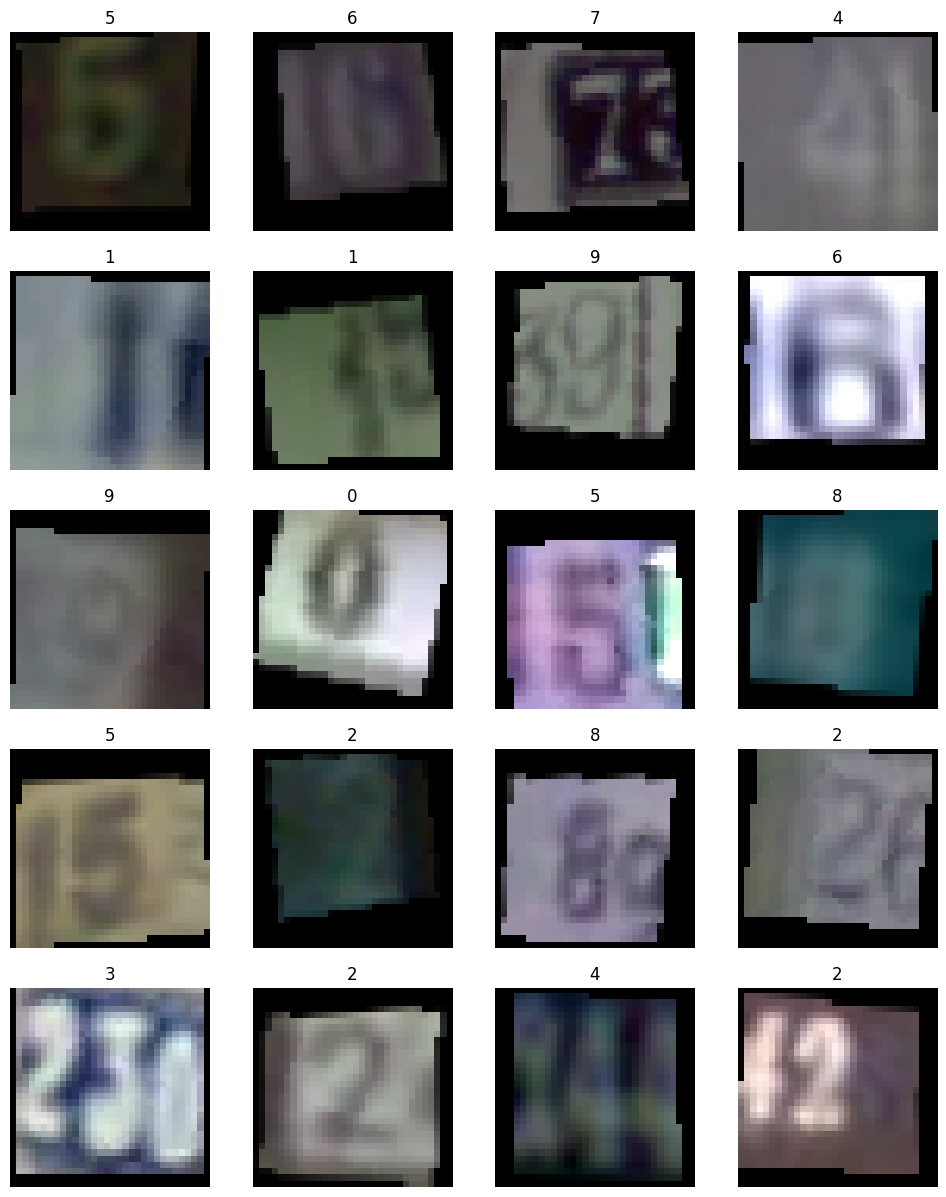

In [5]:
plt.figure(figsize=(12, 15))
train_ds_visualization = train_ds[0]
for i in range(20):
    plt.subplot(5, 4, i + 1)
    img = np.array(Image.fromarray((train_ds_visualization[0][i] * 255).astype(np.uint8), 'RGB'))
    plt.imshow(img / 255, cmap=plt.cm.binary)
    plt.title(np.argmax(train_ds_visualization[1][i]))
    plt.axis('off')
plt.show()

#### Пишем модель

In [6]:
inputs = tf.keras.Input(shape=(32, 32, 3), batch_size=512)
x = tf.keras.layers.Conv2D(50, (3, 3), padding='same')(inputs)
x = tf.keras.layers.MaxPool2D(2)(x)

x = tf.keras.layers.Conv2D(32, (1, 1))(x)
branch1 = tf.keras.layers.Conv2D(32, (1, 1))(x)
branch2 = tf.keras.layers.Conv2D(32, (3, 3), padding='same')(x)
x = tf.keras.layers.add([branch1, branch2])
x = tf.keras.layers.AveragePooling2D(2)(x)

x = tf.keras.layers.Conv2D(64, (1, 1))(x)
branch1 = tf.keras.layers.Conv2D(64, (1, 1))(x)
branch2 = tf.keras.layers.Conv2D(64, (3, 3), padding='same')(x)
x = tf.keras.layers.add([branch1, branch2])
x = tf.keras.layers.MaxPool2D(2)(x)

x = tf.keras.layers.Conv2DTranspose(128, 4)(x)

x = tf.keras.layers.Conv2D(256, (1, 1))(x)
branch1 = tf.keras.layers.Conv2D(256, (1, 1))(x)
branch2 = tf.keras.layers.Conv2D(256, (3, 3), padding='same')(x)
x = tf.keras.layers.add([branch1, branch2])

x = tf.keras.layers.GlobalMaxPool2D()(x)

x = tf.keras.layers.Flatten()(x)
outputs = tf.keras.layers.Dense(10)(x)

model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(512, 32, 32, 3)]   0           []                               
                                                                                                  
 conv2d (Conv2D)                (512, 32, 32, 50)    1400        ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (512, 16, 16, 50)    0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (512, 16, 16, 32)    1632        ['max_pooling2d[0][0]']          
                                                                                              

#### Создаем чекпоинты

In [7]:
metrics = ['categorical_accuracy',
           tfa.metrics.F1Score(num_classes=10, average='macro', name='f1_score')]
num_model = '_g_4'
callbacks = [
    PlotLossesKeras(),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=f'../checkpoints/model{num_model}_categorical_accuracy.h5',
        monitor='val_categorical_accuracy',
        mode='max',
        save_best_only=True,
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=f'../checkpoints/model{num_model}_loss.h5',
        monitor='val_loss',
        mode='min',
        save_best_only=True,
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=f'../checkpoints/model{num_model}_f1_score.h5',
        monitor='val_f1_score',
        mode='max',
        save_best_only=True,
    ),

    tfa.callbacks.AverageModelCheckpoint(
        update_weights=False,
        filepath=f'../checkpoints/model{num_model}_avg_categorical_accuracy.h5',
        monitor='val_categorical_accuracy',
        mode='max',
        save_best_only=True,
    ),
    tfa.callbacks.AverageModelCheckpoint(
        update_weights=False,
        filepath=f'../checkpoints/model{num_model}_avg_loss.h5',
        monitor='val_loss',
        mode='min',
        save_best_only=True,
    ),
    tfa.callbacks.AverageModelCheckpoint(
        update_weights=False,
        filepath=f'../checkpoints/model{num_model}_avg_f1_score.h5',
        monitor='val_f1_score',
        mode='max',
        save_best_only=True,
    )
]

#### Компиляция модели

In [8]:
model.compile(
    optimizer=tfa.optimizers.MovingAverage(tf.keras.optimizers.legacy.Adam()),
    metrics=metrics,
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
)

#### Обучаем модель

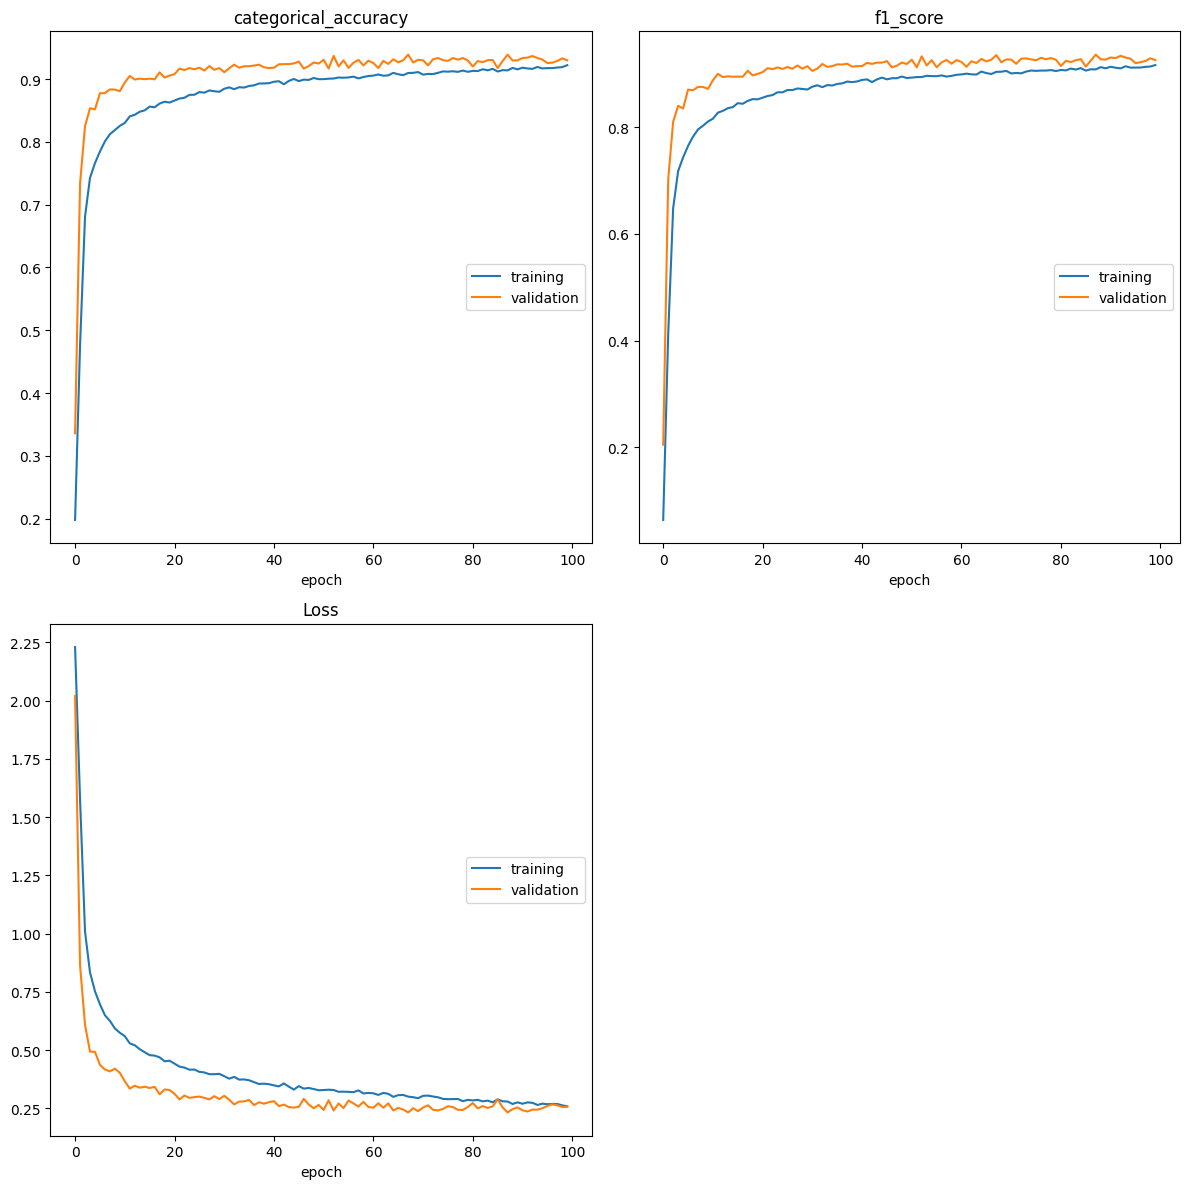

categorical_accuracy
	training         	 (min:    0.198, max:    0.922, cur:    0.922)
	validation       	 (min:    0.336, max:    0.939, cur:    0.930)
f1_score
	training         	 (min:    0.064, max:    0.916, cur:    0.916)
	validation       	 (min:    0.205, max:    0.936, cur:    0.925)
Loss
	training         	 (min:    0.259, max:    2.230, cur:    0.259)
	validation       	 (min:    0.233, max:    2.020, cur:    0.257)
91/91 [==============================] - 295s 3s/step - loss: 0.2592 - categorical_accuracy: 0.9220 - f1_score: 0.9163 - val_loss: 0.2572 - val_categorical_accuracy: 0.9297 - val_f1_score: 0.9255


In [9]:
model.fit(train_ds, validation_data=val_ds,
          epochs=100, callbacks=callbacks, verbose=1)

Продолжил обучение

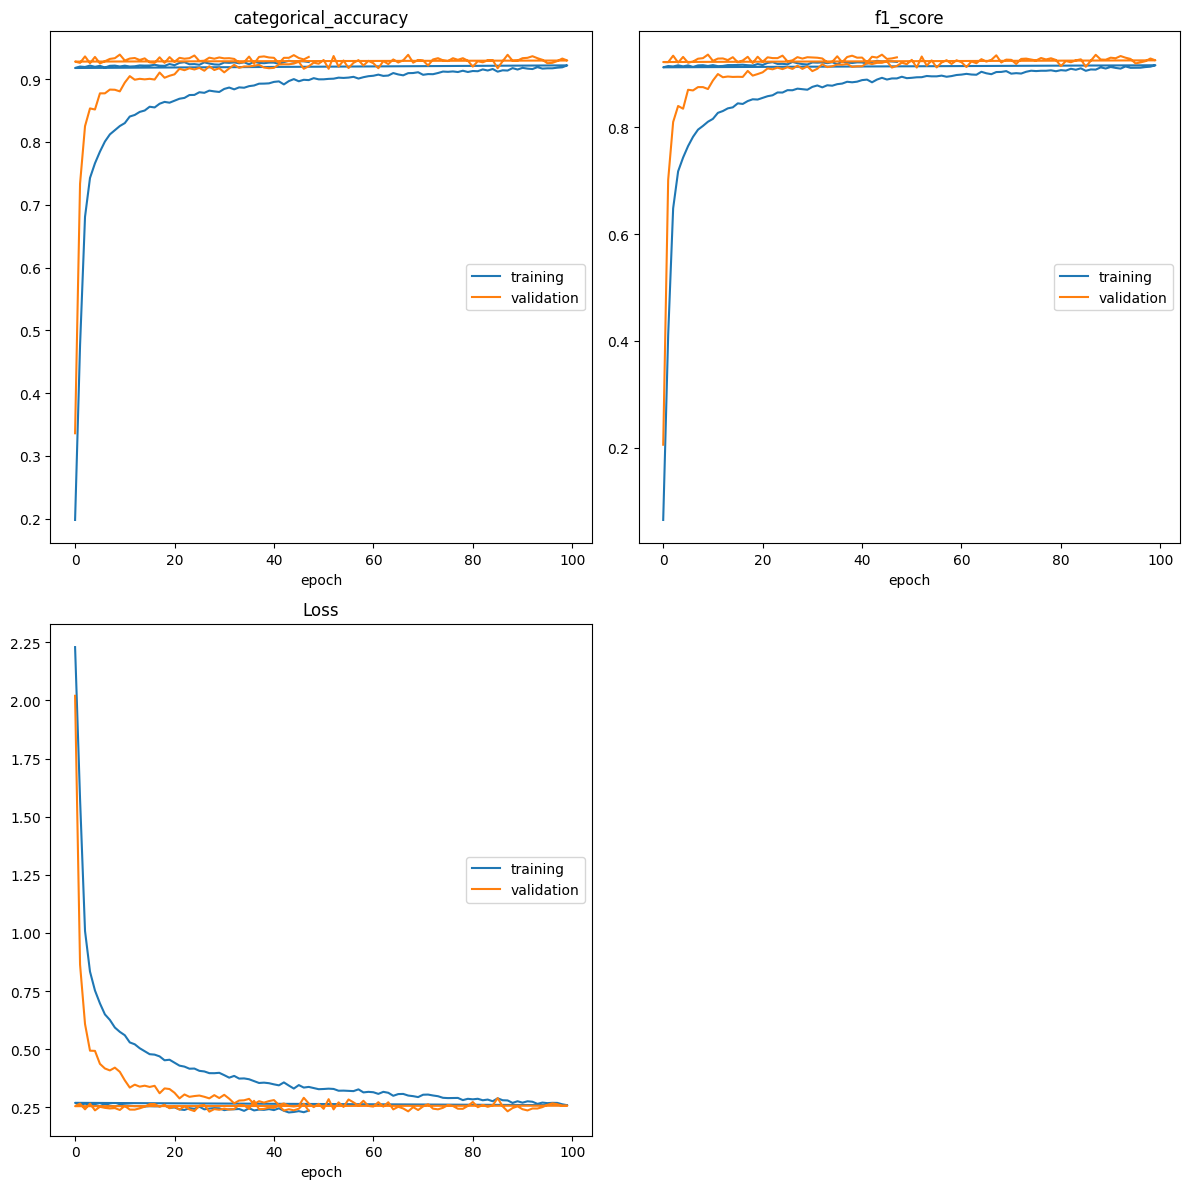

categorical_accuracy
	training         	 (min:    0.198, max:    0.929, cur:    0.927)
	validation       	 (min:    0.336, max:    0.939, cur:    0.935)
f1_score
	training         	 (min:    0.064, max:    0.925, cur:    0.923)
	validation       	 (min:    0.205, max:    0.936, cur:    0.931)
Loss
	training         	 (min:    0.228, max:    2.230, cur:    0.236)
	validation       	 (min:    0.232, max:    2.020, cur:    0.235)
91/91 [==============================] - 389s 4s/step - loss: 0.2360 - categorical_accuracy: 0.9273 - f1_score: 0.9225 - val_loss: 0.2353 - val_categorical_accuracy: 0.9354 - val_f1_score: 0.9311
Epoch 49/50
18/91 [====>.........................] - ETA: 4:04 - loss: 0.2165 - categorical_accuracy: 0.9336 - f1_score: 0.9297

In [20]:
model.fit(train_ds, validation_data=val_ds,
          epochs=50, callbacks=callbacks, verbose=1)

Подгружаем все чекпоинты

In [10]:
model_categorical_acc = tf.keras.models.load_model(f'../checkpoints/model{num_model}_categorical_accuracy.h5')
model_f1_score = tf.keras.models.load_model(f'../checkpoints/model{num_model}_f1_score.h5')
model_loss = tf.keras.models.load_model(f'../checkpoints/model{num_model}_loss.h5')

У нас поличилось три чекпоинта (три модели). Ниже указан код для получения ответов для всех чекпоинтов по валидационному датасету.

In [11]:
ans_val_categorical_accuracy = make_ans_file(model_categorical_acc, val_ds_x)
ans_val_f1_score = make_ans_file(model_f1_score, val_ds_x)
ans_val_loss = make_ans_file(model_loss, val_ds_x)

Формируем валидационные ответы.

In [12]:
val_ds_y = np.argmax(val_ds_y, axis=1)

Сравниваем валидационные предикты каждого чекпоинта

In [13]:
if np.all(ans_val_categorical_accuracy == ans_val_f1_score):
    print('Ответы accuracy чекпоинта совпали с ответами f1_score чекпоинта')
if np.all(ans_val_categorical_accuracy == ans_val_loss):
    print('Ответы accuracy чекпоинта совпали с ответами loss чекпоинта')
if np.all(ans_val_f1_score == ans_val_loss):
    print('Ответы f1_score чекпоинта совпали с ответами loss чекпоинта')

Ответы accuracy чекпоинта совпали с ответами loss чекпоинта


## ВЫВОД:

In [14]:
class MulticlassClassificationMetrics:
    def __init__(self, y_true, y_pred):
        self.y_true = np.array(y_true)
        self.y_pred = np.array(y_pred)
        self.matrix_error = self.get_matrix_error()

    def get_matrix_error(self):
        self.class_types = np.unique([self.y_true, self.y_pred])
        TP, FN, FP, TN = [], [], [], []
        for class_type in self.class_types:
            TP.append(np.sum(np.logical_and(self.y_true == self.y_pred, self.y_true == class_type)))
            FN.append(np.sum(np.logical_and(self.y_true == class_type, self.y_pred != class_type)))
            FP.append(np.sum(np.logical_and(self.y_pred == class_type, self.y_true != class_type)))
            TN.append(np.sum(np.logical_and(self.y_pred != class_type, self.y_true != class_type)))
        return pd.DataFrame({
            'class_type': self.class_types,
            'TP': TP, 'TN': TN, 'FP': FP, 'FN': FN,
        }).set_index('class_type')

    def accuracy(self):
        return np.sum(self.y_true == self.y_pred) / self.y_true.shape[0]

    def precision(self, averaging='macro'):
        if averaging == 'macro':
            precisions = self.matrix_error['TP'] / (self.matrix_error['TP'] + self.matrix_error['FP'])
            return np.mean(precisions.replace(np.nan, 0))
        elif averaging == 'micro':
            mean_val = self.matrix_error.mean()
            return mean_val['TP'] / (mean_val['TP'] + mean_val['FP'])

    def recall(self, averaging='macro'):
        if averaging == 'macro':
            recalls = self.matrix_error['TP'] / (self.matrix_error['TP'] + self.matrix_error['FN'])
            return np.mean(recalls.replace(np.nan, 0))
        elif averaging == 'micro':
            mean_val = self.matrix_error.mean()
            return mean_val['TP'] / (mean_val['TP'] + mean_val['FN'])

    def f1_score(self, averaging='macro'):
        if averaging == 'macro':
            reverse_r = (self.matrix_error['TP'] + self.matrix_error['FN']) / self.matrix_error['TP']
            reverse_p = (self.matrix_error['TP'] + self.matrix_error['FP']) / self.matrix_error['TP']
            f1_scores = 2 / (reverse_r + reverse_p)
            return np.mean(f1_scores.replace(np.nan, 0))
        elif averaging == 'micro':
            p = self.precision(averaging)
            r = self.recall(averaging)
            return 2 * p * r / (p + r)

    def metrics(self, averaging='macro'):
        return {
            'accuracy': self.accuracy(),
            'precision': self.precision(averaging),
            'recall': self.recall(averaging),
            'f1_score': self.f1_score(averaging),
        }

    def __str__(self):
        headers = {
            'selector': '*',
            'props': 'background-color: darkgreen; color: white; font-size: 12pt;',
        }
        che_super_mega_puper_visualization_of_cell = { 
            'selector': 'td:hover',
            'props': 'background-color: green; color: white;',
        }
        display(
            self.matrix_error
            .style
            .set_table_styles([
                headers,
                che_super_mega_puper_visualization_of_cell,
            ])
            .set_properties(**{'background-color': 'lightgreen',
                           'color': 'black', 'font-size': '12pt'})
        )
        return ''

    def __repr__(self):
        return (
            f'MulticlassClassificationMetrics(class_types={self.class_types})'
            .replace("'", '').replace(',', ';'))

### Accuracy чекпоинт

In [15]:
metrics = MulticlassClassificationMetrics(val_ds_y, ans_val_categorical_accuracy)
print(metrics)
metrics.metrics()

,TP,TN,FP,FN
class_type,,,,
0,215,3247,29,10
1,641,2788,36,36
2,533,2916,33,19
3,351,3104,16,30
4,330,3135,16,20
5,305,3152,22,22
6,239,3224,17,21
7,265,3205,15,16
8,190,3275,14,22


{'accuracy': 0.93887460725507,
 'precision': 0.9355568888376384,
 'recall': 0.9347044684240549,
 'f1_score': 0.9348876429750856}

...

### Loss чекпоинт

In [16]:
metrics = MulticlassClassificationMetrics(val_ds_y, ans_val_loss)
print(metrics)
metrics.metrics()

,TP,TN,FP,FN
class_type,,,,
0,215,3247,29,10
1,641,2788,36,36
2,533,2916,33,19
3,351,3104,16,30
4,330,3135,16,20
5,305,3152,22,22
6,239,3224,17,21
7,265,3205,15,16
8,190,3275,14,22


{'accuracy': 0.93887460725507,
 'precision': 0.9355568888376384,
 'recall': 0.9347044684240549,
 'f1_score': 0.9348876429750856}

...

### F1-score чекпоинт

In [17]:
metrics = MulticlassClassificationMetrics(val_ds_y, ans_val_f1_score)
print(metrics)
metrics.metrics()

,TP,TN,FP,FN
class_type,,,,
0,212,3257,19,13
1,639,2790,34,38
2,534,2918,31,18
3,354,3092,28,27
4,330,3129,22,20
5,302,3157,17,25
6,240,3227,14,20
7,270,3191,29,11
8,194,3275,14,18


{'accuracy': 0.93887460725507,
 'precision': 0.9376332931427944,
 'recall': 0.9346352383049595,
 'f1_score': 0.9358312158195268}

...

- Сохраняем ответы.

In [18]:
ans_test_categorical_accuracy = make_ans_file(model_categorical_acc, test_ds, f'../answers/model{num_model}_categorical_accuracy.csv')
ans_test_f1_score = make_ans_file(model_f1_score, test_ds, f'../answers/model{num_model}_f1_score.csv')
ans_test_loss = make_ans_file(model_loss, test_ds, f'../answers/model{num_model}_loss.csv')

Проверяем ответы (одинаковые они или нет), чтоб не терять кол-во отправок ответов на kaggle в день.

In [19]:
if np.all(ans_test_categorical_accuracy == ans_test_f1_score):
    print('Ответы accuracy чекпоинта совпали с ответами f1_score чекпоинта')
if np.all(ans_test_categorical_accuracy == ans_test_loss):
    print('Ответы accuracy чекпоинта совпали с ответами loss чекпоинта')
if np.all(ans_test_f1_score == ans_test_loss):
    print('Ответы f1_score чекпоинта совпали с ответами loss чекпоинта')

Ответы accuracy чекпоинта совпали с ответами loss чекпоинта


Все ответы разные, поэтому отправляем все на kaggle